# Reproducing results

This notebook shows how the results produced by the original paper can be reproduced by running several experiments on different datasets. For the reproduction, the original datasets from the paper are used.

First, we want to do some imports. We also want to define our working directory path.

In [13]:
from matplotlib.font_manager import json_dump
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import sys
import math

#cwd = os.getcwd()

#WORKDIR_PATH = os.path.dirname(os.path.realpath(cwd)) + "/../../"
#sys.path.insert(1, WORKDIR_PATH)


cwd = os.getcwd()
WORKDIR_PATH = os.path.dirname(os.path.dirname(cwd+'/../../'))

sys.path.insert(0, WORKDIR_PATH)

from preprocess_data import preprocess
from base.train_scinet import train_scinet

WORKDIR_PATH = os.path.dirname(os.path.dirname(cwd+'/reprod/'))
sys.path.insert(1, WORKDIR_PATH)


Next, we need to load the data, in this case we will use the "ETTh1.csv' dataset, and do some preprocessing steps before we can use it for training. We indicate what data-format is used, we define the training, validation and test fractions, and the horizon and lookback-window we want to use for training. 

In [18]:
#============= Preprocessing ==============

#data_format = ["timestamp","open","high","low","close","volume",]
data_format = ["price"]
                    
fraction_used = 1
train_frac = 0.6
val_frac = 0.2
test_frac = 0.2

X_LEN = 48
Y_LEN = 24
RANDOM_SEED = 4321#None
OVERLAPPING = True
STANDARDIZE = True

standardization_settings = {'per_sample': True,
                            'leaky': False,
                            'mode': 'log', #only if per sample is false, choose from log, sqrt or lin
                            'sqrt_val': 2, #of course only if mode is sqrt
                            'total mean': [],
                            'total std': []}

pairs = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]

#df = pd.read_csv(os.path.dirname(os.path.dirname(cwd+'/data/Data_preprocessed/ETTh1.csv'))).dropna()
df = pd.read_csv(f"/Users/lindsayspoor/Library/Mobile Documents/com~apple~CloudDocs/Documents/Studiedocumenten/2021-2022/ADL/SCINet_repo/exp/reprod/data/Data_preprocessed/ETTh1.csv").dropna()
df = df.swapaxes("index", "columns")

data = {}
for idx, pair in enumerate(pairs):
    data[pair] = df.iloc[idx]

Next, we want to start the training process, i.e. training SCINet on the dataset. For more instructions on how the training works, follow the instructions in the training_scinet.ipynb notebook. The number of training epochs is set to 150 and the hyperparameters are corresponding with the original set of hyperparameters from the original code:

https://github.com/cure-lab/SCINet/blob/main/Appendix/Appendix.pdf

In [21]:
#================ Training ====================

EPOCHS = 10
BATCH_SIZE = 8
HID_SIZE = 4
NUM_LEVELS = 3
KERNEL_SIZE = 5
DROPOUT = 0.5
LEARNING_RATE = 0.003
PROBABILISTIC = False

# Process data:
results = preprocess(   data = data, 
                        symbols = pairs,
                        data_format = data_format,
                        fraction = fraction_used,
                        train_frac = train_frac,
                        val_frac = val_frac,
                        test_frac = test_frac,
                        X_LEN = X_LEN,
                        Y_LEN = Y_LEN,
                        OVERLAPPING = OVERLAPPING,
                        STANDARDIZE = STANDARDIZE,
                        standardization_settings = standardization_settings
                        )

model, history, X_train , y_train, X_val, y_val, X_test, y_test = train_scinet( X_train = results["X_train"].astype('float32'),
                                                                                y_train = results["y_train"].astype('float32'),
                                                                                X_val = results["X_val"].astype('float32'),
                                                                                y_val = results["y_val"].astype('float32'),
                                                                                X_test = results["X_test"].astype('float32'),
                                                                                y_test = results["y_test"].astype('float32'),
                                                                                epochs = EPOCHS,
                                                                                batch_size = BATCH_SIZE,
                                                                                X_LEN = X_LEN,
                                                                                Y_LEN = [Y_LEN],
                                                                                output_dim = [results["X_train"].shape[2]],
                                                                                selected_columns = None,
                                                                                hid_size= HID_SIZE,
                                                                                num_levels= NUM_LEVELS,
                                                                                kernel = KERNEL_SIZE,
                                                                                dropout = DROPOUT,
                                                                                loss_weights= [1],
                                                                                learning_rate = LEARNING_RATE,
                                                                                probabilistic = PROBABILISTIC)


Starting data preprocessing...
Making train/validation/test splits...
Making samples...


100%|███████████████████████████████████| 10379/10379 [00:01<00:00, 9550.45it/s]


Making samples...


100%|████████████████████████████████████| 3411/3411 [00:00<00:00, 18149.49it/s]


Making samples...


100%|█████████████████████████████████████| 3411/3411 [00:00<00:00, 8905.68it/s]


Making X-y splits...
===========================[SCINET]=====================================
Initializing training with data:
X_train: (10342, 48, 7), y_train: (10342, 24, 7)
X_val: (3411, 48, 7), y_val: (3411, 24, 7)
X_test: (3411, 48, 7), y_test: (3411, 24, 7)
Building model...
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 7)]           0         
_________________________________________________________________
Block_0 (SCINet)             (None, 24, 7)             97332     
Total params: 97,332
Trainable params: 97,332
Non-trainable params: 0
_________________________________________________________________
None
Is null X: 0
Is null y: 0
Epoch 1/10
1293/1293 [==============================] - 31s 16ms/step - loss: 0.8594 - val_loss: 0.7358
Epoch 2/10
1293/1293 [==============================] - 19s 15ms/step - loss: 0.7685 - val_loss: 0.7

# Results 

In order to see whether our training and validation loss meet the results from the original paper, we need to set a target. The targets for MAEs of the corresponding datasets can be found in table 2 in the original paper.

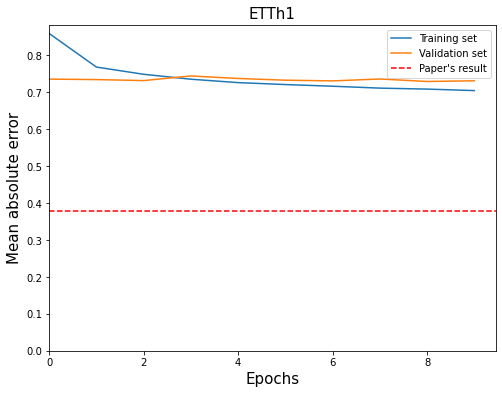

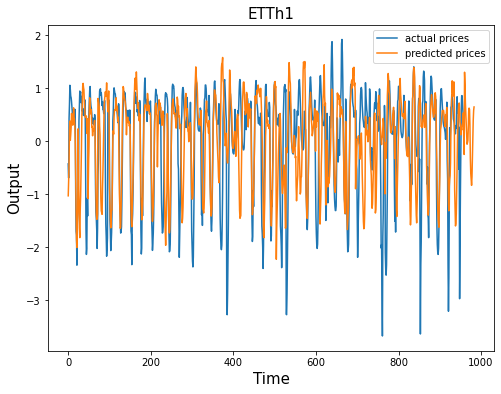

In [22]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
target = 0.379 #value of MAE of paper

X = np.arange(len(train_loss))

plt.figure(figsize=(8,6))
plt.plot(X, train_loss, label='Training set')
plt.plot(X, val_loss, label="Validation set")
plt.axhline(y=target, color='r', linestyle='--', label="Paper's result")
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Mean absolute error', fontsize=15)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.title('ETTh1', fontsize=15)
plt.legend()
#plt.savefig(f"/Users/lindsayspoor/Library/Mobile Documents/com~apple~CloudDocs/Documents/Studiedocumenten/2021-2022/ADL/SCINet_repo/exp/reprod/results/loss_ETTh1_{Y_LEN}.pdf")
plt.show()

output = model(X_test)

series = 0
total_timesteps = 1000

X_time_blocks = math.floor( total_timesteps / X_LEN )
Y_time_blocks = math.floor( total_timesteps / Y_LEN )

actual_prices = np.array([])
for t in range(X_time_blocks):
    actual_prices = np.append(actual_prices, X_test[t*X_LEN,:,series])

predicted_prices = np.array([])
for t in range(Y_time_blocks):
    predicted_prices = np.append(predicted_prices, np.array(output[t*Y_LEN])[:,series])

X_times = np.arange(len(actual_prices))
Y_times = np.arange(len(predicted_prices))
plt.figure(figsize=(8,6))
plt.plot(X_times, actual_prices, label='actual prices')
plt.plot(Y_times, predicted_prices, label='predicted prices')
plt.xlabel('Time', fontsize=15)
plt.ylabel('Output', fontsize=15)
plt.title('ETTh1', fontsize=15)
plt.legend()
#plt.savefig(f"/Users/lindsayspoor/Library/Mobile Documents/com~apple~CloudDocs/Documents/Studiedocumenten/2021-2022/ADL/SCINet_repo/exp/reprod/results/predictions_ETTh1_{Y_LEN}.pdf")
plt.show()